In [6]:
"""
Data from https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation

MRI scan images: FLAIR, T1, T1_ce, T2 and the multilabeled mask.
This script focuses on loading, reading and preparing data.

instal nibabel to help to load data.

Annotations:
0: unlabeled volume
1: necrotic and non-enhancing tumour core
2: peritumoral edema
3: missing                 # we will remove this label
4: GD-enhancing tumour

"""

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Apply MinMaxScaler to normalise the intensity of MRI images
scaler = MinMaxScaler()

# Read one data of image with FLAIR MRI imaging technique and a mask
train_data_path = 'I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\'
image_flair=nib.load(train_data_path + 'BraTS20_Training_020\\BraTS20_Training_020_flair.nii').get_fdata()

print("The highest intensity of FLAIR: ", image_flair.max())

# Use scalers to normalise intensities into 0 to 1
image_flair=scaler.fit_transform(image_flair.reshape(-1,
                                                     image_flair.shape[-1])
                                     ).reshape(image_flair.shape)

print("The highest intensity of normalised FLAIR: ", image_flair.max())

# Read other images with T1, T2 and T1_ce MRI sequences

# T1 image
image_T1=nib.load(train_data_path + 'BraTS20_Training_020\\BraTS20_Training_020_t1.nii').get_fdata()

print("The highest intensity of T1: ", image_T1.max())

image_T1=scaler.fit_transform(image_T1.reshape(-1,
                                                     image_T1.shape[-1])
                                     ).reshape(image_T1.shape)

print("The highest intensity of normalised T1: ", image_T1.max())

# T2 image
image_T2=nib.load(train_data_path + 'BraTS20_Training_020\\BraTS20_Training_020_t2.nii').get_fdata()

print("The highest intensity of T2: ", image_T2.max())

image_T2=scaler.fit_transform(image_T2.reshape(-1,
                                                     image_T2.shape[-1])
                                     ).reshape(image_T2.shape)

print("The highest intensity of normalised T2: ", image_T2.max())

# T1ce image
image_T1ce=nib.load(train_data_path + 'BraTS20_Training_020\\BraTS20_Training_020_t1ce.nii').get_fdata()

print("The highest intensity of T1ce: ", image_T1ce.max())

image_T1ce=scaler.fit_transform(image_T1ce.reshape(-1,
                                                     image_T1ce.shape[-1])
                                     ).reshape(image_T1ce.shape)

print("The highest intensity of normalised T1ce: ", image_T1ce.max())

# Mask
train_data_path = 'I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\'
image_mask=nib.load(train_data_path + 'BraTS20_Training_020\\BraTS20_Training_020_seg.nii').get_fdata()

# Change the datatype to uint8
image_mask = image_mask.astype(np.uint8)

# Check the classes of the mask
print("Category of the mask: ", np.unique(image_mask))

# Adjust [0 1 2 4] to [0 1 2 3]
image_mask[image_mask==4] = 3  # Reassign mask values 4 to 3
print("Changed category: ", np.unique(image_mask)) 


The highest intensity of FLAIR:  894.0
The highest intensity of normalised FLAIR:  1.0
The highest intensity of T1:  677.0
The highest intensity of normalised T1:  1.0
The highest intensity of T2:  500.0
The highest intensity of normalised T2:  1.0
The highest intensity of T1ce:  1443.0
The highest intensity of normalised T1ce:  1.0
Category of the mask:  [0 1 2 4]
Changed category:  [0 1 2 3]


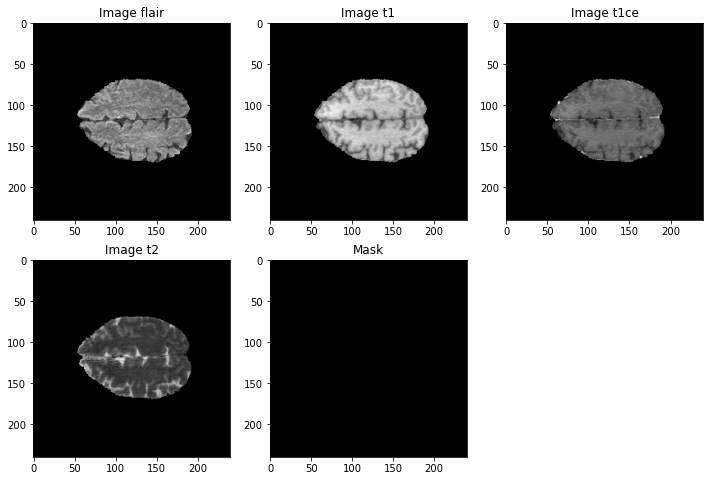

(240, 240, 155)


In [5]:
# Show these MRI images
import random
n_slice=random.randint(0, image_mask.shape[2]-1)

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(image_T1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(image_T1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(image_T2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(image_mask[:,:,n_slice], cmap='gray')
plt.title('Mask')
plt.show()

print(image_flair.shape)

In [6]:
# Reduce the black area (crop 240x240x155 to 128x128x128)

# combined three sequences/techniques with obvious features don't include T1 sequence
combined_x = np.stack([image_flair, image_T1ce, image_T2], axis=3)

print('Combined x size: ', combined_x.shape)

# Cropping this 3D image
combined_x = combined_x[56:184, 56:184, 13:141]

# Cropping this mask too.
image_mask = image_mask[56:184, 56:184, 13:141]



Combined x size:  (240, 240, 155, 3)


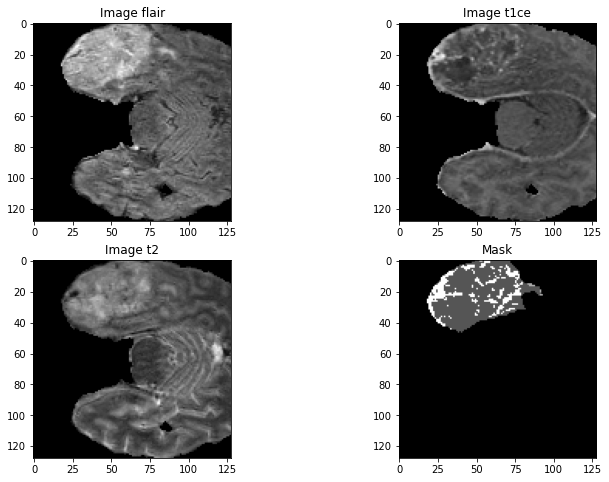

(128, 128, 128, 3)


In [7]:
n_slice=random.randint(0, image_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(image_mask[:,:,n_slice], cmap='gray')
plt.title('Mask')
plt.show()


print(combined_x.shape)

In [8]:
"""
Complete process of resaving four MRI images and one mask to .npy files for training and testing.

"""

t2_list = sorted(glob.glob('I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*t2.nii'))
t1ce_list = sorted(glob.glob('I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*t1ce.nii'))
flair_list = sorted(glob.glob('I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*flair.nii'))
mask_list = sorted(glob.glob('I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*seg.nii'))

print('The number of T2 MRI images for training: ',len(t2_list))
print('The number of T1ce MRI images for training: ',len(t1ce_list))
print('The number of FLAIR MRI images for training: ',len(flair_list))
print('The number of MASK MRI images for training: ',len(mask_list))

The number of T2 MRI images for training:  369
The number of T1ce MRI images for training:  369
The number of FLAIR MRI images for training:  369
The number of MASK MRI images for training:  369


In [9]:
"""
Do the preparation of reading images in each files and then combine T1, T1ce and FLAIR as a cube, and create a segmentation-mask. 
"""
scaler = MinMaxScaler()

for img in range(len(t2_list)):
    print("Preparing image and mask: ", img)
    
    # images
    img_t2 = nib.load(t2_list[img]).get_fdata()
    img_t2 = scaler.fit_transform(img_t2.reshape(-1,
                                                 img_t2.shape[-1])).reshape(img_t2.shape)
    
    img_t1se = nib.load(t1ce_list[img]).get_fdata()
    img_t1se = scaler.fit_transform(img_t1se.reshape(-1,
                                                 img_t1se.shape[-1])).reshape(img_t1se.shape)
    
    img_flair = nib.load(flair_list[img]).get_fdata()
    img_flair = scaler.fit_transform(img_flair.reshape(-1,
                                                 img_flair.shape[-1])).reshape(img_flair.shape)
    
    # mask
    mask = nib.load(mask_list[img]).get_fdata()
    mask = mask.astype(np.uint8)
    # Adjust [0 1 2 4] to [0 1 2 3]
    mask[mask==4] = 3  # Reassign mask values 4 to 3

    com_img = np.stack([img_flair, img_t1se, img_t2], axis=3)
    
    # Cropping img and mmask to 128x128x128
    com_img = com_img[56:184, 56:184, 13:141]
    mask = mask[56:184, 56:184, 13:141]
    
    # Save data into .npy files
    # Check the useful data that masks with enough labels
    val, counts = np.unique(mask, return_counts=True)
    """
    # At least 1% useful volume with labels that are not 0
    """
    if (1 - (counts[0]/counts.sum())) > 0.01:  
        print("Save Me")
        
        temp_mask= to_categorical(mask, num_classes=4)
        np.save('I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\images\\image_'+str(img)+'.npy', com_img)
        np.save('I:\\Data\\Brain MRI\\BraTS2020_TrainingData\\input_data_3channels\\mask\\mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   

    

Preparing image and mask:  0
Save Me
Preparing image and mask:  1
Save Me
Preparing image and mask:  2
Save Me
Preparing image and mask:  3
Save Me
Preparing image and mask:  4
I am useless
Preparing image and mask:  5
Save Me
Preparing image and mask:  6
Save Me
Preparing image and mask:  7
Save Me
Preparing image and mask:  8
Save Me
Preparing image and mask:  9
Save Me
Preparing image and mask:  10
Save Me
Preparing image and mask:  11
Save Me
Preparing image and mask:  12
Save Me
Preparing image and mask:  13
Save Me
Preparing image and mask:  14
Save Me
Preparing image and mask:  15
Save Me
Preparing image and mask:  16
Save Me
Preparing image and mask:  17
Save Me
Preparing image and mask:  18
Save Me
Preparing image and mask:  19
Save Me
Preparing image and mask:  20
Save Me
Preparing image and mask:  21
Save Me
Preparing image and mask:  22
Save Me
Preparing image and mask:  23
Save Me
Preparing image and mask:  24
Save Me
Preparing image and mask:  25
Save Me
Preparing image a

Save Me
Preparing image and mask:  211
Save Me
Preparing image and mask:  212
Save Me
Preparing image and mask:  213
Save Me
Preparing image and mask:  214
Save Me
Preparing image and mask:  215
Save Me
Preparing image and mask:  216
I am useless
Preparing image and mask:  217
Save Me
Preparing image and mask:  218
Save Me
Preparing image and mask:  219
Save Me
Preparing image and mask:  220
Save Me
Preparing image and mask:  221
Save Me
Preparing image and mask:  222
Save Me
Preparing image and mask:  223
Save Me
Preparing image and mask:  224
Save Me
Preparing image and mask:  225
Save Me
Preparing image and mask:  226
Save Me
Preparing image and mask:  227
Save Me
Preparing image and mask:  228
Save Me
Preparing image and mask:  229
Save Me
Preparing image and mask:  230
Save Me
Preparing image and mask:  231
Save Me
Preparing image and mask:  232
I am useless
Preparing image and mask:  233
Save Me
Preparing image and mask:  234
Save Me
Preparing image and mask:  235
Save Me
Prepari

In [3]:
"""
Prepare validation data
"""

t2_list = sorted(glob.glob('I:\\Data\\Brain MRI\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData\\*\\*t2.nii'))
t1ce_list = sorted(glob.glob('I:\\Data\\Brain MRI\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData\\*\\*t1ce.nii'))
flair_list = sorted(glob.glob('I:\\Data\\Brain MRI\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData\\*\\*flair.nii'))

print('The number of T2 MRI images for validation: ',len(t2_list))
print('The number of T1ce MRI images for validation: ',len(t1ce_list))
print('The number of FLAIR MRI images for validation: ',len(flair_list))

The number of T2 MRI images for validation:  124
The number of T1ce MRI images for validation:  125
The number of FLAIR MRI images for validation:  125


In [10]:
scaler = MinMaxScaler()

for img in range(75, len(t2_list)):
    print("Preparing image and mask: ", img)
    
    # images
    img_t2 = nib.load(t2_list[img]).get_fdata()
    img_t2 = scaler.fit_transform(img_t2.reshape(-1,
                                                 img_t2.shape[-1])).reshape(img_t2.shape)
    
    img_t1se = nib.load(t1ce_list[img]).get_fdata()
    img_t1se = scaler.fit_transform(img_t1se.reshape(-1,
                                                 img_t1se.shape[-1])).reshape(img_t1se.shape)
    
    img_flair = nib.load(flair_list[img]).get_fdata()
    img_flair = scaler.fit_transform(img_flair.reshape(-1,
                                                 img_flair.shape[-1])).reshape(img_flair.shape)

    com_img = np.stack([img_flair, img_t1se, img_t2], axis=3)
    
    # Cropping img to 128x128x128
    com_img = com_img[56:184, 56:184, 13:141]
    
    # Save data into .npy files

    print("Save Me")
    np.save('I:\\Data\\Brain MRI\\BraTS2020_ValidationData\\input_data_3channels\\images\\image_'+str(img)+'.npy', com_img)



Preparing image and mask:  75
Save Me
Preparing image and mask:  76
Save Me
Preparing image and mask:  77
Save Me
Preparing image and mask:  78
Save Me
Preparing image and mask:  79
Save Me
Preparing image and mask:  80
Save Me
Preparing image and mask:  81
Save Me
Preparing image and mask:  82
Save Me
Preparing image and mask:  83
Save Me
Preparing image and mask:  84
Save Me
Preparing image and mask:  85
Save Me
Preparing image and mask:  86
Save Me
Preparing image and mask:  87
Save Me
Preparing image and mask:  88
Save Me
Preparing image and mask:  89
Save Me
Preparing image and mask:  90
Save Me
Preparing image and mask:  91
Save Me
Preparing image and mask:  92
Save Me
Preparing image and mask:  93
Save Me
Preparing image and mask:  94
Save Me
Preparing image and mask:  95
Save Me
Preparing image and mask:  96
Save Me
Preparing image and mask:  97
Save Me
Preparing image and mask:  98
Save Me
Preparing image and mask:  99
Save Me
Preparing image and mask:  100
Save Me
Preparing i